<a href="https://colab.research.google.com/github/jjschueder/7331DataMiningNotebooks/blob/master/lab3/Graph_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://scikit-learn.org/stable/auto_examples/cluster/plot_inductive_clustering.html#sphx-glr-auto-examples-cluster-plot-inductive-clustering-py

In [1]:
import pandas as pd

url_dataset = 'https://raw.githubusercontent.com/jjschueder/7331DataMiningNotebooks/master/Live%20Assignments/df1hotmerge2.csv'
data = pd.read_csv(url_dataset, nrows = 30000)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 68 columns):
Unnamed: 0                  30000 non-null int64
pack                        30000 non-null int64
bottle_volume_ml            30000 non-null int64
state_bottle_cost           30000 non-null float64
state_bottle_retail         30000 non-null float64
bottles_sold                30000 non-null int64
sale_dollars                30000 non-null float64
volume_sold_liters          30000 non-null float64
volume_sold_gallons         30000 non-null float64
counter                     30000 non-null int64
liquor_category             30000 non-null object
store_parent                30000 non-null object
month                       30000 non-null object
year                        30000 non-null int64
monthyear                   30000 non-null object
liquor_category_AMARETTO    30000 non-null int64
liquor_category_BRANDY      30000 non-null int64
liquor_category_GIN         30000 non-null i

In [2]:
# Import all necessary libraries we will be using in our dataset

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import math
import re
import sklearn
import random

from sklearn.feature_selection import SelectKBest, chi2, SelectPercentile, RFE, SelectFromModel

from sklearn.preprocessing import StandardScaler, Binarizer

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC

from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, auc, roc_curve
from IPython.display import display, HTML

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, TimeSeriesSplit, StratifiedShuffleSplit

from sklearn.naive_bayes import MultinomialNB

from sklearn.ensemble import GradientBoostingClassifier,GradientBoostingRegressor,AdaBoostClassifier,RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics


%matplotlib inline

matplotlib.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')
print(data.shape)
data.head()

(30000, 68)


,Unnamed: 0,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,counter,liquor_category,store_parent,month,year,monthyear,liquor_category_AMARETTO,liquor_category_BRANDY,liquor_category_GIN,liquor_category_LIQUEUR,liquor_category_Other,liquor_category_RUM,liquor_category_SCHNAPPS,liquor_category_TEQUILA,liquor_category_VODKA,liquor_category_WHISKY,store_parent_CVS,store_parent_Caseys,store_parent_Hy-Vee,store_parent_Kum&Go,store_parent_Other,store_parent_QuikTrip,store_parent_SamsClub,store_parent_SmokingJoes,store_parent_Target,store_parent_Wal-Mart,store_parent_Walgreens,month_Apr,month_Aug,month_Dec,month_Feb,month_Jan,month_Jul,month_Jun,month_Mar,month_May,month_Nov,month_Oct,month_Sep,year_2019,monthyear_Apr-2019,monthyear_Aug-2019,monthyear_Dec-2019,monthyear_Feb-2019,monthyear_Jan-2019,monthyear_Jul-2019,monthyear_Jun-2019,monthyear_Mar-2019,monthyear_May-2019,monthyear_Nov-2019,monthyear_Oct-2019,monthyear_Sep-2019,sale_dollars_trans,cost_per_liter,cost_per_liter_trans,state_bottle_cost_trans,bottles_sold_trans,volume_sold_liters_trans,grossmargin
0,0,20,375,3.85,5.78,20,115.60,7.50,1.98,1,Other,Other,Nov,2019,Nov-19,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,4.750136,15.413333,2.735233,1.348073,2.995732,2.014903,0.333910
1,1,8,50,8.75,13.13,1,13.13,0.05,0.01,1,Other,Other,Nov,2019,Nov-19,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,2.574900,262.600000,5.570632,2.169054,0.000000,-2.995732,0.333587
2,2,12,1000,16.50,24.75,6,148.50,6.00,1.58,1,GIN,Hy-Vee,May,2019,May-19,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,5.000585,24.750000,3.208825,2.803360,1.791759,1.791759,0.333333
3,3,6,750,21.17,31.76,24,762.24,18.00,4.75,1,WHISKY,Hy-Vee,Nov,2019,Nov-19,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,6.636261,42.346667,3.745890,3.052585,3.178054,2.890372,0.333438
4,4,6,1750,9.31,13.97,12,167.64,21.00,5.54,1,Other,Hy-Vee,Nov,2019,Nov-19,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,5.121819,7.982857,2.077296,2.231089,2.484907,3.044522,0.333572


In [3]:
# Since we are predicting our liquor category type (opening to the entire list of categories and not just one), we can assign them a numerical value.

print (data['liquor_category'].unique())

"""df = pd.DataFrame({'col_1':[133,255,36,477,55,63]})
d = {'1':'M', '2': 'C', '3':'a', '4':'f', '5':'r', '6':'s'}
def ifef(col):
    col = str(col)
    return d[col[0]]

df['id_label'] = df['col_1'].apply(ifef)
print(df)"""

d = {'O':'1', 'G': '2', 'W':'3', 'T':'4', 'L':'5', 'V':'6', 'R':'7', 'S': '8', 'A':'9', 'B':'10'}

#data['id_label'] = data['liquor_category'].apply(ifef)

data['id_label'] = data['liquor_category'].astype(str).str[0].map(d)

print(data.head())

['Other' 'GIN' 'WHISKY' 'TEQUILA' 'LIQUEUR' 'VODKA' 'RUM' 'SCHNAPPS'
 'AMARETTO' 'BRANDY']
   Unnamed: 0  pack  ...  grossmargin  id_label
0           0    20  ...     0.333910         1
1           1     8  ...     0.333587         1
2           2    12  ...     0.333333         2
3           3     6  ...     0.333438         3
4           4     6  ...     0.333572         1

[5 rows x 69 columns]


In [0]:
# Create new variables using aggredate data on profit, total cost and revenue

#do some calculations for cost and profit
data['profit'] = data['state_bottle_retail']*data['bottles_sold'] - data['state_bottle_cost']* data['bottles_sold']
data['profit_trans']= np.log(data['profit'])

data['totalcost'] = data['state_bottle_cost']* data['bottles_sold']
data['totalcost_trans']= np.log(data['totalcost'])

data['revenue'] = data['state_bottle_retail']*data['bottles_sold']
data['revenue_trans']= np.log(data['revenue'])

data['bottle_volume_ml_trans']= np.log(data['bottle_volume_ml'])

data['pack_trans']= np.log(data['pack'])

(30000, 11)


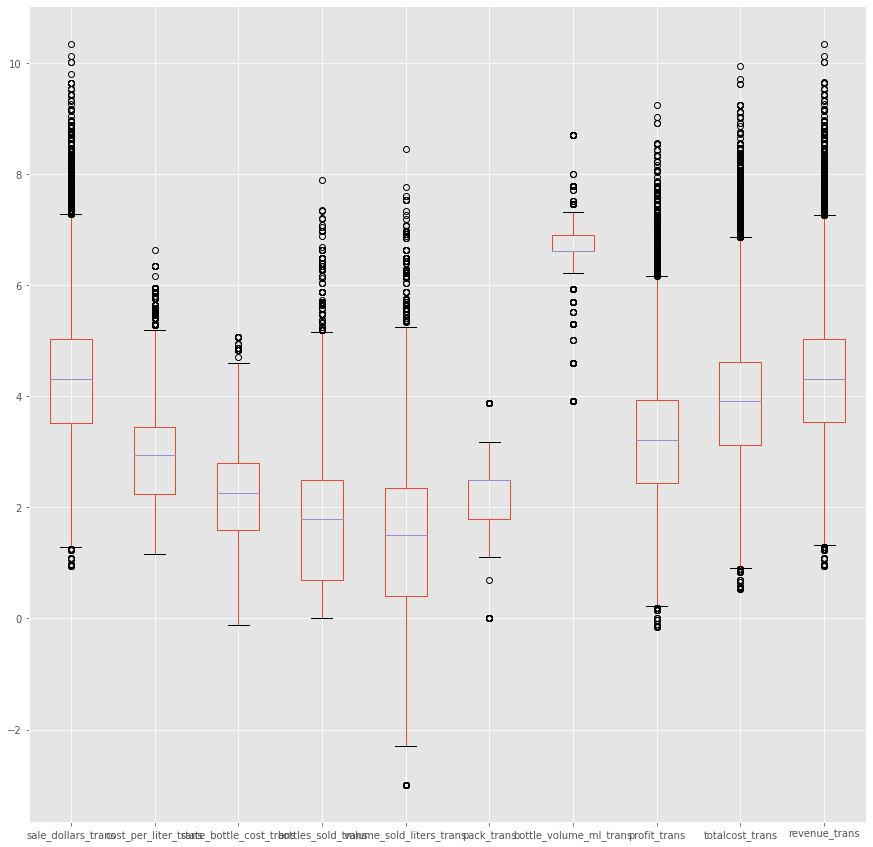

In [5]:
# Since we transformed a number of continuous variables, we can drop them so that we are working directly on our normalized data


# Remove unwanted columns, which include all the specific liquor categories, 
# except for liquor_category_WHISKY since that is what we want to classify on, along
# with all the store_ attributes
"""
cat_vars=['counter', 'liquor_category', 'store_parent',
 'month', 'year', 'monthyear', 'liquor_category_AMARETTO', 'liquor_category_BRANDY', 'liquor_category_GIN', 
 'liquor_category_LIQUEUR', 'liquor_category_Other', 'liquor_category_RUM', 'liquor_category_SCHNAPPS', 
 'liquor_category_TEQUILA', 'liquor_category_VODKA', 'month_Apr', 'month_Aug', 'month_Dec', 'month_Feb',
 'month_Jan', 'month_Jul', 'month_Jun', 'month_Mar', 'month_May', 'month_Nov', 'month_Oct', 'month_Sep', 
 'store_parent_CVS', 'store_parent_Caseys', 'store_parent_Hy-Vee', 'store_parent_Kum&Go', 
 'store_parent_Other', 'store_parent_QuikTrip', 'store_parent_SamsClub', 'store_parent_SmokingJoes', 
 'store_parent_Target', 'store_parent_Wal-Mart', 'store_parent_Walgreens']
data_vars=data.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_vars]
"""
#keep our transformed detail, along with the timing and store name detail

to_keep=['sale_dollars_trans', 'cost_per_liter_trans',
      'state_bottle_cost_trans', 'bottles_sold_trans',
       'volume_sold_liters_trans','pack_trans', 'bottle_volume_ml_trans', 
       'profit_trans', 'totalcost_trans', 'revenue_trans', 'id_label']
data_final=data[to_keep]
data_final.columns.values

#boxplot of all the variables
plt.figure(figsize=(15, 15))
ax = data_final.boxplot()
#ax.set_yscale('log')

print(data_final.shape)

In [6]:
data_final = data_final[data_final['id_label'] < "8"]
data_final = data_final[data_final['id_label'] != "10"]
data_final['id_label'].value_counts()

6    6736
3    6536
7    5515
5    4241
4    2853
1    2386
2    1716
Name: id_label, dtype: int64

In [7]:
%%time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn import metrics as mt

cv = StratifiedKFold(n_splits=10)

features = ['sale_dollars_trans', 'cost_per_liter_trans', 
       'state_bottle_cost_trans', 'bottles_sold_trans',
       'volume_sold_liters_trans', 'pack_trans', 'bottle_volume_ml_trans',
       'profit_trans', 'totalcost_trans', 'revenue_trans']

X2 = data_final[features].copy()

scaler = StandardScaler()
scaler.fit(X2)

#This makes our model's coefficients take on the same scale for accurate feature importance analysis
#Notice we scaled the data before the cross validation
X = scaler.transform(X2)

Y= data_final[['id_label']].copy()

CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 12 ms


In [0]:
from sklearn import metrics as mt

# train and test split before resampling
X1_train, X1_test, y1_train, y1_test = train_test_split(X, Y, test_size = 0.2, random_state = 101) 

In [9]:

print("Before OverSampling, counts of label 'Other': {}".format(sum(y1_train['id_label'] == "1")))
print("Before OverSampling, counts of label 'GIN': {} \n".format(sum(y1_train['id_label'] == "2"))) 
print("Before OverSampling, counts of label 'WHISKY': {} \n".format(sum(y1_train['id_label'] == "3"))) 
print("Before OverSampling, counts of label 'TEQUILA': {}".format(sum(y1_train['id_label'] == "4")))
print("Before OverSampling, counts of label 'LIQUEUR': {} \n".format(sum(y1_train['id_label'] == "5"))) 
print("Before OverSampling, counts of label 'VODKA': {} \n".format(sum(y1_train['id_label'] == "6"))) 
print("Before OverSampling, counts of label 'RUM': {} \n".format(sum(y1_train['id_label'] == "7"))) 


# import SMOTE module from imblearn library 
# pip install imblearn (if you don't have imblearn in your system) 
from imblearn.over_sampling import SMOTE 
sm = SMOTE(random_state = 2) 
X1_train_res, y1_train_res = sm.fit_sample(X1_train, y1_train.values.ravel()) 
  
print('After OverSampling, the shape of train_X: {}'.format(X1_train_res.shape)) 
print('After OverSampling, the shape of train_y: {} \n'.format(y1_train_res.shape)) 
  
print("After OverSampling, counts of label 'Other': {}".format(sum(y1_train_res == "1"))) 
print("After OverSampling, counts of label 'GIN': {}".format(sum(y1_train_res == "2"))) 
print("After OverSampling, counts of label 'WHISKY': {}".format(sum(y1_train_res == "3"))) 
print("After OverSampling, counts of label 'TEQUILA': {}".format(sum(y1_train_res == "4"))) 
print("After OverSampling, counts of label 'LIQUEUR': {}".format(sum(y1_train_res == "5"))) 
print("After OverSampling, counts of label 'VODKA': {}".format(sum(y1_train_res == "6"))) 
print("After OverSampling, counts of label 'RUM': {}".format(sum(y1_train_res == "7"))) 

Before OverSampling, counts of label 'Other': 1913
Before OverSampling, counts of label 'GIN': 1359 

Before OverSampling, counts of label 'WHISKY': 5232 

Before OverSampling, counts of label 'TEQUILA': 2271
Before OverSampling, counts of label 'LIQUEUR': 3383 

Before OverSampling, counts of label 'VODKA': 5413 

Before OverSampling, counts of label 'RUM': 4415 

After OverSampling, the shape of train_X: (37891, 10)
After OverSampling, the shape of train_y: (37891,) 

After OverSampling, counts of label 'Other': 5413
After OverSampling, counts of label 'GIN': 5413
After OverSampling, counts of label 'WHISKY': 5413
After OverSampling, counts of label 'TEQUILA': 5413
After OverSampling, counts of label 'LIQUEUR': 5413
After OverSampling, counts of label 'VODKA': 5413
After OverSampling, counts of label 'RUM': 5413


In [0]:
X2.columns
X1DF = pd.DataFrame(X1_train_res, columns =X2.columns)

In [11]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X1_train_res, y1_train_res)
#X_test = lda.transform(X_test)
lda.explained_variance_ratio_

array([0.80434648, 0.0950707 ])

In [12]:
X_train_lda

array([[-2.23709616, -1.42543504],
       [ 0.48613271, -0.50009817],
       [ 1.25502361, -1.0166834 ],
       ...,
       [-1.31893066,  0.03065644],
       [ 0.65404512,  0.94732615],
       [ 0.27637901,  0.24661858]])

In [0]:
X_train_ldadf=pd.DataFrame(X_train_lda)
X_train_ldadf.columns=['First Component','Second Component']

In [14]:
print(y1_train_res.shape)
ydf = pd.DataFrame(y1_train_res)

(37891,)


In [0]:
ldaydf = X_train_ldadf.merge(ydf, left_index=True, right_index=True)

In [16]:
X_train_ldadf

,First Component,Second Component
0,-2.237096,-1.425435
1,0.486133,-0.500098
2,1.255024,-1.016683
3,-1.941064,-0.350561
4,1.312689,0.335479
...,...,...
37886,0.251752,0.217263
37887,0.755187,-0.933713
37888,-1.318931,0.030656
37889,0.654045,0.947326


In [0]:
ldaydf = ldaydf.rename(columns={0: 'Liquorlabel'})

In [0]:
ldaydf1 = ldaydf.sample(n=4000)
ldaydf2 = ldaydf.sample(n=4000)

In [0]:
features = ['First Component','Second Component']

X1 = ldaydf1[features].copy()
X2 = ldaydf2[features].copy()


Y1= ldaydf1[['Liquorlabel']].copy()
Y2= ldaydf2[['Liquorlabel']].copy()

In [20]:
from google.colab import drive
drive.mount('/content/drive/')
#My Drive/ColabNotebooks/')
url_rfmodel = '/content/drive/My Drive/ColabNotebooks/rfmodelbasecluster.joblib'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [21]:
!pip install turicreate

     |████████████████████████████████| 91.4MB 80kB/s 
     |████████████████████████████████| 327kB 46.8MB/s 
     |████████████████████████████████| 3.4MB 29.6MB/s 
  Created wheel for resampy: filename=resampy-0.2.1-cp36-none-any.whl size=320850 sha256=4e89dc0cb3d645b70716202851243e27674f12668e2f27de100946526c1536be
  Stored in directory: /root/.cache/pip/wheels/ff/4f/ed/2e6c676c23efe5394bb40ade50662e90eb46e29b48324c5f9b
Successfully built resampy
  Found existing installation: resampy 0.2.2
    Uninstalling resampy-0.2.2:
      Successfully uninstalled resampy-0.2.2


In [0]:
import turicreate as tc

In [23]:
sf = tc.SFrame.read_csv(url_dataset)
#sf_morphometry = tc.SFrame.read_csv('train_SBM.csv')

#sf = sf_functional.join(sf_morphometry, on="Id")

#sf = sf.remove_column('id_label')
features = ['sale_dollars_trans', 'cost_per_liter_trans', 
       'state_bottle_cost_trans', 'bottles_sold_trans',
       'volume_sold_liters_trans', 'pack_trans', 'bottle_volume_ml_trans',
       'profit_trans', 'totalcost_trans', 'revenue_trans']


#sf.save('schizophrenia_clean.sframe')

Downloading https://raw.githubusercontent.com/jjschueder/7331DataMiningNotebooks/master/Live%20Assignments/df1hotmerge2.csv to /var/tmp/turicreate-root/2553/facd3f54-397f-4a08-ac85-dc8be682dc91.csv

Finished parsing file https://raw.githubusercontent.com/jjschueder/7331DataMiningNotebooks/master/Live%20Assignments/df1hotmerge2.csv

Parsing completed. Parsed 100 lines in 2.46378 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,int,int,float,float,int,float,float,float,int,str,str,str,int,str,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,float,float,float,float,float,float,float]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Read 218746 lines. Lines per second: 69864.3

Finished parsing file https://raw.githubusercontent.com/jjschueder/7331DataMiningNotebooks/master/Live%20Assignments/df1hotmerge2.csv

Parsing completed. Parsed 400000 lines in 3.56387 secs.

In [24]:
sf

X1,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters
0,20,375,3.85,5.78,20,115.6,7.5
1,8,50,8.75,13.13,1,13.13,0.05
2,12,1000,16.5,24.75,6,148.5,6.0
3,6,750,21.17,31.76,24,762.24,18.0
4,6,1750,9.31,13.97,12,167.64,21.0
5,12,1000,28.98,43.47,6,260.82,6.0
6,12,500,4.9,7.35,12,88.2,6.0
7,6,750,8.5,12.75,30,382.5,22.5
8,8,300,8.75,13.13,2,26.26,0.6
9,6,1000,33.34,50.01,6,300.06,6.0


In [0]:
#do some calculations for cost and profit
sf['profit'] = sf['state_bottle_retail']*sf['bottles_sold'] - sf['state_bottle_cost']* sf['bottles_sold']
sf['profit_trans']= np.log(sf['profit'])

sf['totalcost'] = sf['state_bottle_cost']* sf['bottles_sold']
sf['totalcost_trans']= np.log(sf['totalcost'])

sf['revenue'] = sf['state_bottle_retail']*sf['bottles_sold']
sf['revenue_trans']= np.log(sf['revenue'])

sf['bottle_volume_ml_trans']= np.log(sf['bottle_volume_ml'])

sf['pack_trans']= np.log(sf['pack'])

sf2 = sf['sale_dollars_trans', 'cost_per_liter_trans', 
       'state_bottle_cost_trans', 'bottles_sold_trans',
       'volume_sold_liters_trans', 'pack_trans', 'bottle_volume_ml_trans',
       'profit_trans', 'totalcost_trans', 'revenue_trans']

In [26]:
sf

X1,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters
0,20,375,3.85,5.78,20,115.6,7.5
1,8,50,8.75,13.13,1,13.13,0.05
2,12,1000,16.5,24.75,6,148.5,6.0
3,6,750,21.17,31.76,24,762.24,18.0
4,6,1750,9.31,13.97,12,167.64,21.0
5,12,1000,28.98,43.47,6,260.82,6.0
6,12,500,4.9,7.35,12,88.2,6.0
7,6,750,8.5,12.75,30,382.5,22.5
8,8,300,8.75,13.13,2,26.26,0.6
9,6,1000,33.34,50.01,6,300.06,6.0


In [27]:
sf2

sale_dollars_trans,cost_per_liter_trans,state_bottle_cost_trans,bottles_sold_trans,volume_sold_liters_trans
4.750135956,2.735232936,1.348073148,2.995732274,2.014903021
2.574899688,5.570631962,2.1690537,0.0,-2.995732274
5.000584958,3.208825489,2.803360381,1.791759469,1.791759469
6.636261467,3.745889709,3.052585085,3.17805383,2.890371758
5.121818823,2.077296385,2.231089091,2.48490665,3.044522438
5.563830514,3.772071045,3.366605937,1.791759469,1.791759469
4.479606963,2.687847494,1.589235205,2.48490665,1.791759469
5.946728653,2.833213344,2.140066163,3.401197382,3.113515309
3.268046869,3.778872493,2.1690537,0.693147181,-0.510825624
5.703982455,3.912222985,3.506757877,1.791759469,1.791759469


In [28]:
from math import sqrt
K = int(sqrt(len(sf2) / 2.0))

kmeans_model = tc.kmeans.create(sf2, num_clusters=K)
kmeans_model.summary()

Batch size is larger than the input dataset. Switching to an exact Kmeans method.

Choosing initial cluster centers with Kmeans++.

+---------------+-----------+

| Center number | Row index |

+---------------+-----------+

| 0             | 272125    |

| 1             | 399999    |

| 2             | 399999    |

| 3             | 399999    |

| 4             | 399999    |

| 5             | 399999    |

| 10            | 399999    |

| 50            | 399999    |

| 100           | 399999    |

| 446           | 399999    |

+---------------+-----------+

Starting kmeans model training.

Assigning points to initial cluster centers.

+-----------+-------------------------------+

| Iteration | Number of changed assignments |

+-----------+-------------------------------+

| 1         | 80                            |

| 2         | 13532                         |

| 3         | 28368                         |

| 4         | 25478                         |

| 5         | 19062                         |

| 6         | 12456                         |

| 7         | 7797                          |

| 8         | 6230                          |

| 9         | 2194                          |

| 10        | 1373                          |

+-----------+-------------------------------+

WARNING: Clustering did not converge within max_iterations.

Class                            : KmeansModel

Schema
------
Number of clusters               : 447
Number of examples               : 400000
Number of feature columns        : 10
Number of unpacked features      : 10
Row label name                   : row_id

Training Summary
----------------
Training method                  : elkan
Number of training iterations    : 10
Batch size                       : 400000
Total training time (seconds)    : 10.9709

Accessible fields
-----------------
cluster_id                      : An SFrame containing the cluster assignments.
cluster_info                    : An SFrame containing the cluster centers.


In [29]:
K

447

In [30]:
kmeans_model.cluster_info.print_rows(num_columns=5, max_row_width=80,
                                        max_column_width=10)

+-----------+------------+-----------+-----------+-----------+-----+
| profit... | pack_trans | totalc... | bottle... | state_... | ... |
+-----------+------------+-----------+-----------+-----------+-----+
|    nan    | 2.2021...  | 5.0953... | 2.5283... | 2.5669... | ... |
| 3.2974... | 2.2827...  | 3.9898... | 2.1800... | 1.8098... | ... |
| 2.0228... | 2.4591...  | 2.7153... | 0.6800... | 2.0352... | ... |
|    0.0    |    0.0     |    0.0    |    0.0    |    0.0    | ... |
|    0.0    |    0.0     |    0.0    |    0.0    |    0.0    | ... |
|    0.0    |    0.0     |    0.0    |    0.0    |    0.0    | ... |
|    0.0    |    0.0     |    0.0    |    0.0    |    0.0    | ... |
|    0.0    |    0.0     |    0.0    |    0.0    |    0.0    | ... |
|    0.0    |    0.0     |    0.0    |    0.0    |    0.0    | ... |
|    0.0    |    0.0     |    0.0    |    0.0    |    0.0    | ... |
+-----------+------------+-----------+-----------+-----------+-----+
[447 rows x 13 columns]



In [31]:
kmeans_model.cluster_info[['cluster_id', 'size', 'sum_squared_distance']]

cluster_id,size,sum_squared_distance
0,113835,nan
1,169595,422386.7688784674
2,116570,547459.3754948336
3,0,0.0
4,0,0.0
5,0,0.0
6,0,0.0
7,0,0.0
8,0,0.0
9,0,0.0


In [32]:
kmeans_model.cluster_id.head()

row_id,cluster_id,distance
0,1,1.7177931070327759
1,2,4.7215070724487305
2,0,nan
3,0,nan
4,1,1.9777723550796509
5,0,nan
6,1,0.9381688833236694
7,0,nan
8,2,1.1168203353881836
9,0,nan


In [33]:
kmeans_model2 = tc.kmeans.create(sf2, num_clusters=7, max_iterations=1)

Batch size is larger than the input dataset. Switching to an exact Kmeans method.

Choosing initial cluster centers with Kmeans++.

+---------------+-----------+

| Center number | Row index |

+---------------+-----------+

| 0             | 130932    |

| 1             | 399999    |

| 2             | 399999    |

| 3             | 399999    |

| 4             | 399999    |

| 5             | 399999    |

| 6             | 399999    |

+---------------+-----------+

Starting kmeans model training.

Assigning points to initial cluster centers.

+-----------+-------------------------------+

| Iteration | Number of changed assignments |

+-----------+-------------------------------+

| 1         | 0                             |

+-----------+-------------------------------+

In [34]:
kmeans_model2.summary()

Class                            : KmeansModel

Schema
------
Number of clusters               : 7
Number of examples               : 400000
Number of feature columns        : 10
Number of unpacked features      : 10
Row label name                   : row_id

Training Summary
----------------
Training method                  : elkan
Number of training iterations    : 1
Batch size                       : 400000
Total training time (seconds)    : 0.5037

Accessible fields
-----------------
cluster_id                      : An SFrame containing the cluster assignments.
cluster_info                    : An SFrame containing the cluster centers.


In [35]:
kmeans_model2.cluster_info[['cluster_id', 'size', 'sum_squared_distance']]

cluster_id,size,sum_squared_distance
0,115266,nan
1,284734,1265067.7814074531
2,0,0.0
3,0,0.0
4,0,0.0
5,0,0.0
6,0,0.0


In [36]:
kmeans_model3 = tc.kmeans.create(sf2, num_clusters=7, batch_size=30,
                                max_iterations=10)
kmeans_model3.summary()

Choosing initial cluster centers with Kmeans++.

+---------------+-----------+

| Center number | Row index |

+---------------+-----------+

| 0             | 171468    |

| 1             | 399999    |

| 2             | 399999    |

| 3             | 399999    |

| 4             | 399999    |

| 5             | 399999    |

| 6             | 399999    |

+---------------+-----------+

Starting kmeans model training.

+-----------+

| Iteration |

+-----------+

| 0         |

| 1         |

| 2         |

| 3         |

| 4         |

| 5         |

| 6         |

| 7         |

| 8         |

| 9         |

+-----------+

Class                            : KmeansModel

Schema
------
Number of clusters               : 7
Number of examples               : 400000
Number of feature columns        : 10
Number of unpacked features      : 10
Row label name                   : row_id

Training Summary
----------------
Training method                  : minibatch
Number of training iterations    : 10
Batch size                       : 30
Total training time (seconds)    : 0.469

Accessible fields
-----------------
cluster_id                      : An SFrame containing the cluster assignments.
cluster_info                    : An SFrame containing the cluster centers.


In [37]:
kmeans_model3.cluster_info

Columns:
	profit_trans	float
	pack_trans	float
	totalcost_trans	float
	bottles_sold_trans	float
	state_bottle_cost_trans	float
	revenue_trans	float
	volume_sold_liters_trans	float
	sale_dollars_trans	float
	bottle_volume_ml_trans	float
	cost_per_liter_trans	float
	cluster_id	int
	size	int
	sum_squared_distance	float

Rows: 7

Data:
+--------------------+--------------------+--------------------+
|    profit_trans    |     pack_trans     |  totalcost_trans   |
+--------------------+--------------------+--------------------+
| 2.106985247506236  | 2.3689236735456527 | 2.7997213872477436 |
| 3.584352870036167  | 2.0820271161723882 | 4.277101119918607  |
| 4.764862113845529  | 2.1930552053417074 | 5.457563920089423  |
| 3.5548072214845288 | 3.227564343245085  | 4.246458995133946  |
| 3.1751953799150803 | 2.1302732085712837 | 3.867650704020101  |
| 3.9661056566793427 | 2.4849066497880004 | 4.658994392172182  |
| 3.780550855699916  | 2.2538575896013517 | 4.472809283423768  |
+--------------------+--------------------+--------------------+
+--------------------+-------------------------+--------------------+
| bottles_sold_trans | state_bottle_cost_trans |   revenue_trans    |
+--------------------+-------------------------+--------------------+
| 0.6281625950891089 |    2.1715587923564352   | 3.2053236758004093 |
| 1.8289594458701295 |    2.4481416739480526   | 4.682699277686136  |
| 2.9836128663947368 |    2.473951053921053    | 5.863177551136543  |
| 3.499468806714286  |    0.7469901882142855   |  4.65242385235159  |
| 2.1488431550000002 |    1.7188075489999997   | 4.273346607763505  |
|     2.48490665     |    2.1740877425416665   | 5.064545679208691  |
|     2.48490665     |    1.9879026336666668   | 4.878570774211302  |
+--------------------+-------------------------+--------------------+
+--------------------------+--------------------+------------------------+
| volume_sold_liters_trans | sale_dollars_trans | bottle_volume_ml_trans |
+--------------------------+--------------------+------------------------+
|   0.14906453548514859    | 3.2047021572079215 |   6.429188230586607    |
|    1.8629472350779221    | 4.6889464901948035 |   6.941743068239593    |
|    3.0134040141578953    | 5.862791200763159  |   6.9375464269524025   |
|    2.1995559105714286    | 4.652423852428572  |   5.608011801892255    |
|    2.3481845593720934    | 4.277196060325584  |   7.107096683463675    |
|    2.2211980830833333    | 5.064545679166668  |   6.644046712568005    |
|       2.671445246        | 4.878570774666667  |   7.094293874960611    |
+--------------------------+--------------------+------------------------+
+----------------------+------------+--------+----------------------+
| cost_per_liter_trans | cluster_id |  size  | sum_squared_distance |
+----------------------+------------+--------+----------------------+
|  3.0556376218019814  |     0      | 119476 |         inf          |
|  2.8259992550779214  |     1      | 71213  |  168403.6830085069   |
|  2.8493871863947366  |     2      | 36734  |  220259.42206043005  |
|  2.4528679414285715  |     3      | 22721  |   82502.0045517385   |
|  1.9290115009069768  |     4      | 73011  |  70260.06620761752   |
|  2.8433475958750005  |     5      | 55741  |  47969.95069072116   |
|  2.2071255286666664  |     6      | 21104  |  22167.612179532647  |
+----------------------+------------+--------+----------------------+
[7 rows x 13 columns]

In [38]:
labels_as_sframe = kmeans_model3.cluster_id

labels_as_sframe.show()

Materializing SFrame

In [39]:
labels_as_sframe

row_id,cluster_id,distance
0,3,0.9605172276496887
1,0,4.961663722991943
2,1,0.9180648326873779
3,2,1.9607529640197754
4,6,0.8970014452934265
5,5,2.0040197372436523
6,1,1.4320595264434814
7,2,0.7654609680175781
8,0,1.260401725769043
9,2,2.317857265472412


ERROR! Session/line number was not unique in database. History logging moved to new session 62
[[4.75013596 2.73523294 1.34807315 ... 3.65325228 4.34380542 4.75013596]
 [2.57489969 5.57063196 2.1690537  ... 1.47704872 2.1690537  2.57489969]
 [5.00058496 3.20882549 2.80336038 ... 3.90197267 4.59511985 5.00058496]
 ...
 [4.90438549 2.70716092 2.0135688  ... 3.80666249 4.49847545 4.90438549]
 [4.90438549 2.70716092 2.0135688  ... 3.80666249 4.49847545 4.90438549]
 [4.90438549 2.70716092 2.0135688  ... 3.80666249 4.49847545 4.90438549]] [3, 0, 1, 2, 6, 5, 1, 2, 0, 2, 6, 0, 1, 0, 2, 2, 2, 2, 1, 0, 2, 2, 0, 5, 1, 0, 0, 1, 1, 2, 2, 2, 2, 0, 1, 1, 0, 1, 1, 0, 6, 1, 6, 1, 1, 1, 2, 0, 4, 0, 2, 1, 0, 0, 0, 1, 0, 2, 1, 0, 0, 0, 0, 2, 1, 0, 5, 1, 0, 6, 0, 0, 0, 2, 0, 1, 0, 2, 2, 1, 0, 1, 1, 2, 2, 2, 0, 1, 0, 2, 0, 1, 1, 2, 5, 0, 1, 2, 2, 0, ... ]


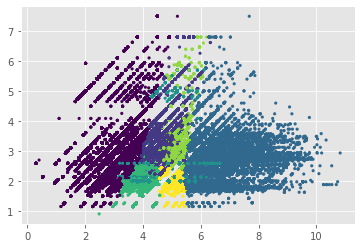

In [40]:
X = sf2.to_dataframe().values
print (X,labels_as_sframe['cluster_id'])
plt.scatter(X[:,0], X[:,1], c=labels_as_sframe['cluster_id'],
                     s=10, linewidths=0)

plt.show()